In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pathlib as Path
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [3]:
# Note - You must set up your own config file
from config import db_password

In [4]:
# Name the SQL database your are accessing
database = "RealLeads"

# Make your local connection to the database in PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database=database,
    user="postgres",
    password=db_password)

In [5]:
# Table selection Function
def table_select(table_name):
    table =f"select * from \"{table_name}\""
    dataFrame = pd.read_sql(table, conn)
    return dataFrame

In [6]:
# Names of the tables to be imported
prop_charac = table_select("prop_charac_clean")
pub_rec = table_select("pub_rec_clean")
sales_data = table_select("sales_data_clean")

In [7]:
prop_charac.head()

,MLSNumber,Address,BuildingName,Ownership,Senior_Community_YN,Condo/Coop_Assoc_YN,HOA_YN,AssociationFee,AssociationFeeFrequency,Structure_Type,...,Garage_YN,GarageSpaces,GarageFeatures,Parking,ExteriorFeatures,ExteriorMaterial,Main_Roof,Foundation,PorchDeck,SwimmingPoolType
0,DENC518086,2615 Pecksniff Rd,NONE AVAILABLE,FeeSimple,No,No,Yes,$15,Annually,Detached,...,Yes,1.0,None,None,"ExtensiveHardscape,Sidewalks,StoneRetainingWal...","BrickFront,VinylSiding",ArchitecturalShingle,None,"Patios,Porches",None
1,DENC518982,4938 S Tupelo Turn,None,FeeSimple,No,No,No,None,None,Interior Row/Townhouse,...,No,NaN,None,None,None,"AluminumSiding,Brick,VinylSiding",Asphalt,None,None,None
2,DENC512992,15 Kristina Ct,None,FeeSimple,No,No,No,None,None,Interior Row/Townhouse,...,No,NaN,None,None,None,VinylSiding,None,None,None,None
3,DENC512104,3251 Champions Dr,None,FeeSimple,No,No,Yes,$50,Annually,Interior Row/Townhouse,...,Yes,1.0,None,None,None,Other,Shingle,None,Patios,None
4,DENC503480,3706 Lafayette St,None,FeeSimple,No,No,No,None,None,Detached,...,No,NaN,None,None,None,Asbestos,None,None,None,None


In [8]:
prop_charac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MLSNumber                  5576 non-null   object 
 1   Address                    5576 non-null   object 
 2   BuildingName               1139 non-null   object 
 3   Ownership                  5576 non-null   object 
 4   Senior_Community_YN        5576 non-null   object 
 5   Condo/Coop_Assoc_YN        5576 non-null   object 
 6   HOA_YN                     5576 non-null   object 
 7   AssociationFee             1582 non-null   object 
 8   AssociationFeeFrequency    1582 non-null   object 
 9   Structure_Type             5576 non-null   object 
 10  Acres                      5354 non-null   float64
 11  LotDimensions              4847 non-null   object 
 12  LotDescription             1455 non-null   object 
 13  FeeIncludes                661 non-null    objec

In [9]:
pub_rec.head()

,MLSNumber,Tax_ID,Address-truncated,PropertyCityState,Zip_Code,Zip4,CarrierRoute,PropDoNotMail,OwnerNames,OwnerLastName,...,BldgSqFtTotal,Stories,Bedrooms,Exterior,BsmtDesc,FireplaceTotal,GrgType,HeatDelivery,YearBuilt,YearRemod
0,DENC518086,08-038.30-119,2615 Pecksniff,"Wilmington, DE",19808,3026,C010,N,James Robinson,Robinson,...,1875.0,1.0,3.0,"Brick, Aluminum, Vinyl",Finished,0.0,Att/BuiltIn/Bsmt,Hot Water/Steam,1958,0
1,DENC518982,08-036.10-081,4938 S Tupelo,"Wilmington, DE",19808,1026,C009,N,Xiaopeng Deng,Deng,...,1575.0,2.0,3.0,"Brick, Aluminum, Vinyl",Finished,0.0,None,Hot/Warm Air,1976,0
2,DENC512992,08-044.30-363,15 Kristina,"Wilmington, DE",19808,4063,C084,N,Robert F Walls,Walls,...,NaN,2.0,2.0,"Aluminum, Vinyl",None,0.0,None,Heat Pump,1985,0
3,DENC512104,08-036.40-376,3251 Champions,"Wilmington, DE",19808,2601,C039,N,Michael J Downs,Downs,...,NaN,2.0,2.0,Other,None,1.0,Att/BuiltIn/Bsmt,Heat Pump,1985,0
4,DENC503480,07-041.10-071,3706 Lafayette,"Wilmington, DE",19808,6014,C001,N,Maria Corona,Corona,...,NaN,1.0,3.0,Asbestos,None,0.0,None,Hot/Warm Air,1957,0


In [10]:
pub_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MLSNumber                5576 non-null   object 
 1   Tax_ID                   5576 non-null   object 
 2   Address-truncated        5576 non-null   object 
 3   PropertyCityState        5576 non-null   object 
 4   Zip_Code                 5576 non-null   object 
 5   Zip4                     5576 non-null   object 
 6   CarrierRoute             5572 non-null   object 
 7   PropDoNotMail            5573 non-null   object 
 8   OwnerNames               5246 non-null   object 
 9   OwnerLastName            5206 non-null   object 
 10  OwnerFirstName           4917 non-null   object 
 11  Owner2LastName           2359 non-null   object 
 12  Owner2FirstName          2359 non-null   object 
 13  Owner3LastName           89 non-null     object 
 14  Owner3FirstName         

In [11]:
sales_data.head()

,MLSNumber,Address,Status,Sold_Price,Sold_Price_less_Concession,Orig_List_Price,Current_List_Price,Days_on_Market,Previous_Days_on_Market,ListDate,StatusDate,Agreement_of_Sale_Date,SettledDate,Concessions_YN,Concessions_Remarks,SellerConcessionsAmount,FinalFinancing
0,DENC518086,2615 Pecksniff Rd,Closed,335000.0,335000.0,330000.0,330000.0,5.0,5.0,2020-12-11,2021-02-11,2020-12-16,2021-02-11,No,None,0.0,FHA
1,DENC518982,4938 S Tupelo Turn,Closed,200000.0,200000.0,215500.0,210000.0,47.0,67.0,2021-01-07,2021-04-08,2021-02-21,2021-04-08,No,None,0.0,Conventional
2,DENC512992,15 Kristina Ct,Closed,200000.0,200000.0,200000.0,200000.0,15.0,15.0,2020-12-28,2021-02-26,2021-01-09,2021-02-26,No,None,0.0,Conventional
3,DENC512104,3251 Champions Dr,Closed,200000.0,200000.0,219900.0,214900.0,11.0,11.0,2020-10-27,2020-12-14,2020-11-05,2020-12-11,No,None,0.0,Conventional
4,DENC503480,3706 Lafayette St,Closed,200000.0,200000.0,190000.0,190000.0,3.0,3.0,2020-06-20,2020-08-02,2020-06-21,2020-07-31,No,None,0.0,Conventional


In [12]:
sales_data['FinalFinancing'].value_counts()

Conventional              3466
FHA                       1086
Cash                       705
VA                         248
FHA203b                     20
Other                       16
FHA203k                      6
Private                      6
AdjustableRateMortgage       5
FHA,FHA203b                  4
Seller                       2
Cash,Conventional            2
Negotiable                   1
Conventional,VA              1
LeasePurchase                1
OwnerFinancing,Private       1
CDA,Conventional             1
Cash,SellerTake1st           1
SellerPaysCC                 1
FHA,VA                       1
CommercialWrap               1
FmHA                         1
Name: FinalFinancing, dtype: int64

In [14]:
# Look at NAME value counts for binning
loan_counts = sales_data.FinalFinancing.value_counts()
#  How many name counts are greater than 5?
loan_counts[loan_counts<20]

Other                     16
FHA203k                    6
Private                    6
AdjustableRateMortgage     5
FHA,FHA203b                4
Seller                     2
Cash,Conventional          2
Negotiable                 1
Conventional,VA            1
LeasePurchase              1
OwnerFinancing,Private     1
CDA,Conventional           1
Cash,SellerTake1st         1
SellerPaysCC               1
FHA,VA                     1
CommercialWrap             1
FmHA                       1
Name: FinalFinancing, dtype: int64

In [15]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MLSNumber                   5576 non-null   object 
 1   Address                     5576 non-null   object 
 2   Status                      5576 non-null   object 
 3   Sold_Price                  5576 non-null   float64
 4   Sold_Price_less_Concession  5576 non-null   float64
 5   Orig_List_Price             5576 non-null   float64
 6   Current_List_Price          5576 non-null   float64
 7   Days_on_Market              5576 non-null   float64
 8   Previous_Days_on_Market     5576 non-null   float64
 9   ListDate                    5576 non-null   object 
 10  StatusDate                  5576 non-null   object 
 11  Agreement_of_Sale_Date      5576 non-null   object 
 12  SettledDate                 5576 non-null   object 
 13  Concessions_YN              5576 

In [16]:
sales_data['ListDate'].head()

0    2020-12-11
1    2021-01-07
2    2020-12-28
3    2020-10-27
4    2020-06-20
Name: ListDate, dtype: object

In [17]:
sales_data['ListDate'] = pd.to_datetime(sales_data['ListDate'])

In [18]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   MLSNumber                   5576 non-null   object        
 1   Address                     5576 non-null   object        
 2   Status                      5576 non-null   object        
 3   Sold_Price                  5576 non-null   float64       
 4   Sold_Price_less_Concession  5576 non-null   float64       
 5   Orig_List_Price             5576 non-null   float64       
 6   Current_List_Price          5576 non-null   float64       
 7   Days_on_Market              5576 non-null   float64       
 8   Previous_Days_on_Market     5576 non-null   float64       
 9   ListDate                    5576 non-null   datetime64[ns]
 10  StatusDate                  5576 non-null   object        
 11  Agreement_of_Sale_Date      5576 non-null   object      

In [19]:
sales_data['Month'] = pd.DatetimeIndex(sales_data['ListDate']).month

In [20]:
sales_data['Year'] = pd.DatetimeIndex(sales_data['ListDate']).year

In [21]:
# Drop Rows from prop_charac
prop_charac = prop_charac[['MLSNumber',
                            'Bedrooms',
                            'Baths',
                            'Basement_YN',
                            'Garage_YN',
                            'AboveGradeSqFt',
                            'BelowGradeSqFt',
                            'Condo/Coop_Assoc_YN',
                            'Central_Air_YN',
                            'HOA_YN',
                            'Age',
                          'Ownership',
                          'Structure_Type',
                          'InteriorSqFt',
                          'NumberofStories']]

prop_charac

,MLSNumber,Bedrooms,Baths,Basement_YN,Garage_YN,AboveGradeSqFt,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories
0,DENC518086,4.0,2.0,Yes,Yes,2099.0,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,2099.0,"Main,Upper1"
1,DENC518982,3.0,2.0,Yes,No,1575.0,352.0,No,Yes,No,1976.0,FeeSimple,Interior Row/Townhouse,1927.0,"Main,Upper1"
2,DENC512992,2.0,2.0,Yes,No,1150.0,0.0,No,Yes,No,1985.0,FeeSimple,Interior Row/Townhouse,1150.0,"Main,Upper1"
3,DENC512104,2.0,3.0,Yes,Yes,1425.0,0.0,No,Yes,Yes,1985.0,FeeSimple,Interior Row/Townhouse,1425.0,"Main,Upper1"
4,DENC503480,3.0,2.0,Yes,No,925.0,0.0,No,Yes,No,1957.0,FeeSimple,Detached,925.0,Main
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,DENC520114,3.0,2.0,Yes,Yes,3045.0,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,3045.0,"Lower1,Main"
5572,DENC520392,4.0,4.0,Yes,Yes,3175.0,636.0,No,Yes,Yes,1973.0,FeeSimple,Detached,3811.0,"Lower1,Main,Upper1"
5573,DENC2014038,4.0,3.0,Yes,Yes,2850.0,341.0,No,Yes,No,1989.0,FeeSimple,Detached,3191.0,"Lower1,Main,Upper1"
5574,DENC2005484,4.0,3.0,Yes,Yes,3425.0,0.0,No,Yes,No,1992.0,FeeSimple,Detached,3425.0,"Lower1,Main,Upper1"


In [22]:
# Drop Rows from pub_rec
pub_rec = pub_rec[['MLSNumber',
                    'Zip_Code',
                    'SchoolDistrict',
                    'AnnualTax',
                    'LotAcres',
                    'SubdivisionNeighborhood',
                    'Municipality',
                      'Lot',
                      'OwnerOccupied',
                      'TotalLandAsmt',
                  'TotalBldgAsmt',
                  'PropertyClass',
                  'YearBuilt']]

pub_rec

,MLSNumber,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,Lot,OwnerOccupied,TotalLandAsmt,TotalBldgAsmt,PropertyClass,YearBuilt
0,DENC518086,19808,Red Clay Consolidated,2151,0.26,Sherwood Park Ii,Mill Creek Hundred,119,True,12600,52600,Residential,1958
1,DENC518982,19808,Red Clay Consolidated,1824,0.06,Pepper Ridge,Mill Creek Hundred,81,False,9900,45400,Residential,1976
2,DENC512992,19808,Red Clay Consolidated,1563,0.05,Woodmill,Mill Creek Hundred,363,False,9400,38000,Residential,1985
3,DENC512104,19808,Red Clay Consolidated,2174,0.05,Fairway Falls,Mill Creek Hundred,376,True,8600,57300,Residential,1985
4,DENC503480,19808,Red Clay Consolidated,1349,0.17,Washington Hgts,Christiana Hundred,71,True,8600,32300,Residential,1957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,DENC520114,19707,Red Clay Consolidated,4311,1.03,Canterbury Hills,Mill Creek Hundred,46,True,31300,99400,Residential,1958
5572,DENC520392,19707,Red Clay Consolidated,5208,0.75,None,Christiana Hundred,54,True,25200,132700,Residential,1973
5573,DENC2014038,19707,Red Clay Consolidated,4407,0.39,Stenning Woods,Mill Creek Hundred,27,True,30000,103600,Residential,1989
5574,DENC2005484,19707,Red Clay Consolidated,4825,0.54,Quaker Lea Villas,Mill Creek Hundred,16,True,28500,117800,Residential,1992


In [23]:
# Drop Rows from sales_data

sales_data = sales_data[['MLSNumber',
                        'Days_on_Market',
                        'Orig_List_Price',
                         'Month',
                         'Year'
                        ]]

sales_data

,MLSNumber,Days_on_Market,Orig_List_Price,Month,Year
0,DENC518086,5.0,330000.0,12,2020
1,DENC518982,47.0,215500.0,1,2021
2,DENC512992,15.0,200000.0,12,2020
3,DENC512104,11.0,219900.0,10,2020
4,DENC503480,3.0,190000.0,6,2020
...,...,...,...,...,...
5571,DENC520114,5.0,595000.0,6,2021
5572,DENC520392,25.0,639000.0,3,2021
5573,DENC2014038,7.0,529900.0,1,2022
5574,DENC2005484,25.0,620000.0,8,2021


In [24]:
# Merge sales_data and pub_rec dataframes
merge_df = pd.merge(sales_data, pub_rec, on='MLSNumber')
merge_df

,MLSNumber,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,Lot,OwnerOccupied,TotalLandAsmt,TotalBldgAsmt,PropertyClass,YearBuilt
0,DENC518086,5.0,330000.0,12,2020,19808,Red Clay Consolidated,2151,0.26,Sherwood Park Ii,Mill Creek Hundred,119,True,12600,52600,Residential,1958
1,DENC518982,47.0,215500.0,1,2021,19808,Red Clay Consolidated,1824,0.06,Pepper Ridge,Mill Creek Hundred,81,False,9900,45400,Residential,1976
2,DENC512992,15.0,200000.0,12,2020,19808,Red Clay Consolidated,1563,0.05,Woodmill,Mill Creek Hundred,363,False,9400,38000,Residential,1985
3,DENC512104,11.0,219900.0,10,2020,19808,Red Clay Consolidated,2174,0.05,Fairway Falls,Mill Creek Hundred,376,True,8600,57300,Residential,1985
4,DENC503480,3.0,190000.0,6,2020,19808,Red Clay Consolidated,1349,0.17,Washington Hgts,Christiana Hundred,71,True,8600,32300,Residential,1957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,DENC520114,5.0,595000.0,6,2021,19707,Red Clay Consolidated,4311,1.03,Canterbury Hills,Mill Creek Hundred,46,True,31300,99400,Residential,1958
5572,DENC520392,25.0,639000.0,3,2021,19707,Red Clay Consolidated,5208,0.75,None,Christiana Hundred,54,True,25200,132700,Residential,1973
5573,DENC2014038,7.0,529900.0,1,2022,19707,Red Clay Consolidated,4407,0.39,Stenning Woods,Mill Creek Hundred,27,True,30000,103600,Residential,1989
5574,DENC2005484,25.0,620000.0,8,2021,19707,Red Clay Consolidated,4825,0.54,Quaker Lea Villas,Mill Creek Hundred,16,True,28500,117800,Residential,1992


In [25]:
# Merge merge_df and prop_charac dataframes
merge_df = pd.merge(merge_df, prop_charac, on='MLSNumber')
merge_df

,MLSNumber,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,...,AboveGradeSqFt,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories
0,DENC518086,5.0,330000.0,12,2020,19808,Red Clay Consolidated,2151,0.26,Sherwood Park Ii,...,2099.0,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,2099.0,"Main,Upper1"
1,DENC518982,47.0,215500.0,1,2021,19808,Red Clay Consolidated,1824,0.06,Pepper Ridge,...,1575.0,352.0,No,Yes,No,1976.0,FeeSimple,Interior Row/Townhouse,1927.0,"Main,Upper1"
2,DENC512992,15.0,200000.0,12,2020,19808,Red Clay Consolidated,1563,0.05,Woodmill,...,1150.0,0.0,No,Yes,No,1985.0,FeeSimple,Interior Row/Townhouse,1150.0,"Main,Upper1"
3,DENC512104,11.0,219900.0,10,2020,19808,Red Clay Consolidated,2174,0.05,Fairway Falls,...,1425.0,0.0,No,Yes,Yes,1985.0,FeeSimple,Interior Row/Townhouse,1425.0,"Main,Upper1"
4,DENC503480,3.0,190000.0,6,2020,19808,Red Clay Consolidated,1349,0.17,Washington Hgts,...,925.0,0.0,No,Yes,No,1957.0,FeeSimple,Detached,925.0,Main
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5571,DENC520114,5.0,595000.0,6,2021,19707,Red Clay Consolidated,4311,1.03,Canterbury Hills,...,3045.0,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,3045.0,"Lower1,Main"
5572,DENC520392,25.0,639000.0,3,2021,19707,Red Clay Consolidated,5208,0.75,None,...,3175.0,636.0,No,Yes,Yes,1973.0,FeeSimple,Detached,3811.0,"Lower1,Main,Upper1"
5573,DENC2014038,7.0,529900.0,1,2022,19707,Red Clay Consolidated,4407,0.39,Stenning Woods,...,2850.0,341.0,No,Yes,No,1989.0,FeeSimple,Detached,3191.0,"Lower1,Main,Upper1"
5574,DENC2005484,25.0,620000.0,8,2021,19707,Red Clay Consolidated,4825,0.54,Quaker Lea Villas,...,3425.0,0.0,No,Yes,No,1992.0,FeeSimple,Detached,3425.0,"Lower1,Main,Upper1"


In [26]:
# Info for all columns in new dataframe
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5576 entries, 0 to 5575
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MLSNumber                5576 non-null   object 
 1   Days_on_Market           5576 non-null   float64
 2   Orig_List_Price          5576 non-null   float64
 3   Month                    5576 non-null   int64  
 4   Year                     5576 non-null   int64  
 5   Zip_Code                 5576 non-null   object 
 6   SchoolDistrict           5576 non-null   object 
 7   AnnualTax                5576 non-null   int64  
 8   LotAcres                 5576 non-null   float64
 9   SubdivisionNeighborhood  5288 non-null   object 
 10  Municipality             5576 non-null   object 
 11  Lot                      5576 non-null   object 
 12  OwnerOccupied            5576 non-null   bool   
 13  TotalLandAsmt            5576 non-null   int64  
 14  TotalBldgAsmt           

In [27]:
# Determine the number of unique values in each column.
merge_df.nunique()

MLSNumber                  5576
Days_on_Market              200
Orig_List_Price             618
Month                        12
Year                          6
Zip_Code                     15
SchoolDistrict                4
AnnualTax                  2540
LotAcres                    173
SubdivisionNeighborhood     619
Municipality                 12
Lot                         844
OwnerOccupied                 2
TotalLandAsmt               376
TotalBldgAsmt              1139
PropertyClass                 4
YearBuilt                   154
Bedrooms                      9
Baths                         7
Basement_YN                   2
Garage_YN                     2
AboveGradeSqFt              478
BelowGradeSqFt              611
Condo/Coop_Assoc_YN           2
Central_Air_YN                2
HOA_YN                        2
Age                         166
Ownership                     4
Structure_Type                9
InteriorSqFt               1133
NumberofStories              35
dtype: i

In [28]:
# Find null rows
merge_df.isna().sum()

MLSNumber                    0
Days_on_Market               0
Orig_List_Price              0
Month                        0
Year                         0
Zip_Code                     0
SchoolDistrict               0
AnnualTax                    0
LotAcres                     0
SubdivisionNeighborhood    288
Municipality                 0
Lot                          0
OwnerOccupied                0
TotalLandAsmt                0
TotalBldgAsmt                0
PropertyClass                0
YearBuilt                    0
Bedrooms                     5
Baths                        5
Basement_YN                  0
Garage_YN                    0
AboveGradeSqFt               0
BelowGradeSqFt             182
Condo/Coop_Assoc_YN          0
Central_Air_YN               0
HOA_YN                       0
Age                          0
Ownership                    0
Structure_Type               0
InteriorSqFt                 0
NumberofStories              5
dtype: int64

In [29]:
# Drop rows with null values
merge_df = merge_df.dropna()
merge_df

,MLSNumber,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,...,AboveGradeSqFt,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories
0,DENC518086,5.0,330000.0,12,2020,19808,Red Clay Consolidated,2151,0.26,Sherwood Park Ii,...,2099.0,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,2099.0,"Main,Upper1"
1,DENC518982,47.0,215500.0,1,2021,19808,Red Clay Consolidated,1824,0.06,Pepper Ridge,...,1575.0,352.0,No,Yes,No,1976.0,FeeSimple,Interior Row/Townhouse,1927.0,"Main,Upper1"
2,DENC512992,15.0,200000.0,12,2020,19808,Red Clay Consolidated,1563,0.05,Woodmill,...,1150.0,0.0,No,Yes,No,1985.0,FeeSimple,Interior Row/Townhouse,1150.0,"Main,Upper1"
3,DENC512104,11.0,219900.0,10,2020,19808,Red Clay Consolidated,2174,0.05,Fairway Falls,...,1425.0,0.0,No,Yes,Yes,1985.0,FeeSimple,Interior Row/Townhouse,1425.0,"Main,Upper1"
4,DENC503480,3.0,190000.0,6,2020,19808,Red Clay Consolidated,1349,0.17,Washington Hgts,...,925.0,0.0,No,Yes,No,1957.0,FeeSimple,Detached,925.0,Main
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5570,DENC2013538,5.0,589900.0,12,2021,19707,Red Clay Consolidated,3503,0.82,Berkeley Ridge,...,2425.0,0.0,No,Yes,No,1957.0,FeeSimple,Detached,2425.0,"Lower1,Main"
5571,DENC520114,5.0,595000.0,6,2021,19707,Red Clay Consolidated,4311,1.03,Canterbury Hills,...,3045.0,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,3045.0,"Lower1,Main"
5573,DENC2014038,7.0,529900.0,1,2022,19707,Red Clay Consolidated,4407,0.39,Stenning Woods,...,2850.0,341.0,No,Yes,No,1989.0,FeeSimple,Detached,3191.0,"Lower1,Main,Upper1"
5574,DENC2005484,25.0,620000.0,8,2021,19707,Red Clay Consolidated,4825,0.54,Quaker Lea Villas,...,3425.0,0.0,No,Yes,No,1992.0,FeeSimple,Detached,3425.0,"Lower1,Main,Upper1"


In [30]:
# Find max days on market
merge_df['Days_on_Market'].max()

655.0

In [31]:
# Check binning
pd.cut(merge_df['Days_on_Market'], bins=8).value_counts()

(-0.655, 81.875]     4931
(81.875, 163.75]      136
(163.75, 245.625]      20
(245.625, 327.5]       13
(327.5, 409.375]        4
(491.25, 573.125]       3
(573.125, 655.0]        2
(409.375, 491.25]       1
Name: Days_on_Market, dtype: int64

In [32]:
# Drop rows with condition over 120 days on market
merge_df.drop(merge_df[merge_df['Days_on_Market'] >= 120].index, inplace = True)

C:\Users\madel\anaconda3\envs\mlenv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
clean_df = merge_df.copy()

In [36]:
# Cut data
cut_labels = ['Less than 2 months', 'More than 2 months']
cut_bins = [0, 60,120]
clean_df['DaysOnMarket_Buckets'] = pd.cut(clean_df['Days_on_Market'], bins=cut_bins, labels=cut_labels)
clean_df

,MLSNumber,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,...,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
0,DENC518086,5.0,330000.0,12,2020,19808,Red Clay Consolidated,2151,0.26,Sherwood Park Ii,...,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,2099.0,"Main,Upper1",Less than 2 months
1,DENC518982,47.0,215500.0,1,2021,19808,Red Clay Consolidated,1824,0.06,Pepper Ridge,...,352.0,No,Yes,No,1976.0,FeeSimple,Interior Row/Townhouse,1927.0,"Main,Upper1",Less than 2 months
2,DENC512992,15.0,200000.0,12,2020,19808,Red Clay Consolidated,1563,0.05,Woodmill,...,0.0,No,Yes,No,1985.0,FeeSimple,Interior Row/Townhouse,1150.0,"Main,Upper1",Less than 2 months
3,DENC512104,11.0,219900.0,10,2020,19808,Red Clay Consolidated,2174,0.05,Fairway Falls,...,0.0,No,Yes,Yes,1985.0,FeeSimple,Interior Row/Townhouse,1425.0,"Main,Upper1",Less than 2 months
4,DENC503480,3.0,190000.0,6,2020,19808,Red Clay Consolidated,1349,0.17,Washington Hgts,...,0.0,No,Yes,No,1957.0,FeeSimple,Detached,925.0,Main,Less than 2 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5570,DENC2013538,5.0,589900.0,12,2021,19707,Red Clay Consolidated,3503,0.82,Berkeley Ridge,...,0.0,No,Yes,No,1957.0,FeeSimple,Detached,2425.0,"Lower1,Main",Less than 2 months
5571,DENC520114,5.0,595000.0,6,2021,19707,Red Clay Consolidated,4311,1.03,Canterbury Hills,...,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,3045.0,"Lower1,Main",Less than 2 months
5573,DENC2014038,7.0,529900.0,1,2022,19707,Red Clay Consolidated,4407,0.39,Stenning Woods,...,341.0,No,Yes,No,1989.0,FeeSimple,Detached,3191.0,"Lower1,Main,Upper1",Less than 2 months
5574,DENC2005484,25.0,620000.0,8,2021,19707,Red Clay Consolidated,4825,0.54,Quaker Lea Villas,...,0.0,No,Yes,No,1992.0,FeeSimple,Detached,3425.0,"Lower1,Main,Upper1",Less than 2 months


In [37]:
# Change index to MLSNumber
clean_df = clean_df.set_index('MLSNumber')
clean_df

,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,...,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
MLSNumber,,,,,,,,,,,,,,,,,,,,,
DENC518086,5.0,330000.0,12,2020,19808,Red Clay Consolidated,2151,0.26,Sherwood Park Ii,Mill Creek Hundred,...,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,2099.0,"Main,Upper1",Less than 2 months
DENC518982,47.0,215500.0,1,2021,19808,Red Clay Consolidated,1824,0.06,Pepper Ridge,Mill Creek Hundred,...,352.0,No,Yes,No,1976.0,FeeSimple,Interior Row/Townhouse,1927.0,"Main,Upper1",Less than 2 months
DENC512992,15.0,200000.0,12,2020,19808,Red Clay Consolidated,1563,0.05,Woodmill,Mill Creek Hundred,...,0.0,No,Yes,No,1985.0,FeeSimple,Interior Row/Townhouse,1150.0,"Main,Upper1",Less than 2 months
DENC512104,11.0,219900.0,10,2020,19808,Red Clay Consolidated,2174,0.05,Fairway Falls,Mill Creek Hundred,...,0.0,No,Yes,Yes,1985.0,FeeSimple,Interior Row/Townhouse,1425.0,"Main,Upper1",Less than 2 months
DENC503480,3.0,190000.0,6,2020,19808,Red Clay Consolidated,1349,0.17,Washington Hgts,Christiana Hundred,...,0.0,No,Yes,No,1957.0,FeeSimple,Detached,925.0,Main,Less than 2 months
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DENC2013538,5.0,589900.0,12,2021,19707,Red Clay Consolidated,3503,0.82,Berkeley Ridge,Mill Creek Hundred,...,0.0,No,Yes,No,1957.0,FeeSimple,Detached,2425.0,"Lower1,Main",Less than 2 months
DENC520114,5.0,595000.0,6,2021,19707,Red Clay Consolidated,4311,1.03,Canterbury Hills,Mill Creek Hundred,...,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,3045.0,"Lower1,Main",Less than 2 months
DENC2014038,7.0,529900.0,1,2022,19707,Red Clay Consolidated,4407,0.39,Stenning Woods,Mill Creek Hundred,...,341.0,No,Yes,No,1989.0,FeeSimple,Detached,3191.0,"Lower1,Main,Upper1",Less than 2 months


In [38]:
# Change object columns to category
for label, content in clean_df.items():
    if pd.api.types.is_string_dtype(content):
        clean_df[label] = content.astype("category").cat.as_ordered()
        
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5019 entries, DENC518086 to DENC526982
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Days_on_Market           5019 non-null   float64 
 1   Orig_List_Price          5019 non-null   float64 
 2   Month                    5019 non-null   int64   
 3   Year                     5019 non-null   int64   
 4   Zip_Code                 5019 non-null   category
 5   SchoolDistrict           5019 non-null   category
 6   AnnualTax                5019 non-null   int64   
 7   LotAcres                 5019 non-null   float64 
 8   SubdivisionNeighborhood  5019 non-null   category
 9   Municipality             5019 non-null   category
 10  Lot                      5019 non-null   category
 11  OwnerOccupied            5019 non-null   bool    
 12  TotalLandAsmt            5019 non-null   int64   
 13  TotalBldgAsmt            5019 non-null   int64   
 14

In [39]:
clean_df.head()

,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,...,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
MLSNumber,,,,,,,,,,,,,,,,,,,,,
DENC518086,5.0,330000.0,12,2020,19808,Red Clay Consolidated,2151,0.26,Sherwood Park Ii,Mill Creek Hundred,...,0.0,No,Yes,Yes,1958.0,FeeSimple,Detached,2099.0,"Main,Upper1",Less than 2 months
DENC518982,47.0,215500.0,1,2021,19808,Red Clay Consolidated,1824,0.06,Pepper Ridge,Mill Creek Hundred,...,352.0,No,Yes,No,1976.0,FeeSimple,Interior Row/Townhouse,1927.0,"Main,Upper1",Less than 2 months
DENC512992,15.0,200000.0,12,2020,19808,Red Clay Consolidated,1563,0.05,Woodmill,Mill Creek Hundred,...,0.0,No,Yes,No,1985.0,FeeSimple,Interior Row/Townhouse,1150.0,"Main,Upper1",Less than 2 months
DENC512104,11.0,219900.0,10,2020,19808,Red Clay Consolidated,2174,0.05,Fairway Falls,Mill Creek Hundred,...,0.0,No,Yes,Yes,1985.0,FeeSimple,Interior Row/Townhouse,1425.0,"Main,Upper1",Less than 2 months
DENC503480,3.0,190000.0,6,2020,19808,Red Clay Consolidated,1349,0.17,Washington Hgts,Christiana Hundred,...,0.0,No,Yes,No,1957.0,FeeSimple,Detached,925.0,Main,Less than 2 months


In [40]:
# Change categories to numbers
for label,content in clean_df.items():
    if not pd.api.types.is_numeric_dtype(content):
        clean_df[label] = pd.Categorical(content).codes+1

In [41]:
clean_df.head()

,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,...,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
MLSNumber,,,,,,,,,,,,,,,,,,,,,
DENC518086,5.0,330000.0,12,2020,13,4,2151,0.26,445,4,...,0.0,1,2,2,1958.0,3,1,2099.0,27,1
DENC518982,47.0,215500.0,1,2021,13,4,1824,0.06,385,4,...,352.0,1,2,1,1976.0,3,4,1927.0,27,1
DENC512992,15.0,200000.0,12,2020,13,4,1563,0.05,600,4,...,0.0,1,2,1,1985.0,3,4,1150.0,27,1
DENC512104,11.0,219900.0,10,2020,13,4,2174,0.05,184,4,...,0.0,1,2,2,1985.0,3,4,1425.0,27,1
DENC503480,3.0,190000.0,6,2020,13,4,1349,0.17,526,2,...,0.0,1,2,1,1957.0,3,1,925.0,26,1


In [42]:
# Drop rows with null values
clean_df = clean_df.dropna()
clean_df

,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,...,BelowGradeSqFt,Condo/Coop_Assoc_YN,Central_Air_YN,HOA_YN,Age,Ownership,Structure_Type,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
MLSNumber,,,,,,,,,,,,,,,,,,,,,
DENC518086,5.0,330000.0,12,2020,13,4,2151,0.26,445,4,...,0.0,1,2,2,1958.0,3,1,2099.0,27,1
DENC518982,47.0,215500.0,1,2021,13,4,1824,0.06,385,4,...,352.0,1,2,1,1976.0,3,4,1927.0,27,1
DENC512992,15.0,200000.0,12,2020,13,4,1563,0.05,600,4,...,0.0,1,2,1,1985.0,3,4,1150.0,27,1
DENC512104,11.0,219900.0,10,2020,13,4,2174,0.05,184,4,...,0.0,1,2,2,1985.0,3,4,1425.0,27,1
DENC503480,3.0,190000.0,6,2020,13,4,1349,0.17,526,2,...,0.0,1,2,1,1957.0,3,1,925.0,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DENC2013538,5.0,589900.0,12,2021,1,4,3503,0.82,39,4,...,0.0,1,2,1,1957.0,3,1,2425.0,11,1
DENC520114,5.0,595000.0,6,2021,1,4,4311,1.03,83,4,...,0.0,1,2,2,1958.0,3,1,3045.0,11,1
DENC2014038,7.0,529900.0,1,2022,1,4,4407,0.39,470,4,...,341.0,1,2,1,1989.0,3,1,3191.0,12,1


In [43]:
clean_df.columns

Index(['Days_on_Market', 'Orig_List_Price', 'Month', 'Year', 'Zip_Code',
       'SchoolDistrict', 'AnnualTax', 'LotAcres', 'SubdivisionNeighborhood',
       'Municipality', 'Lot', 'OwnerOccupied', 'TotalLandAsmt',
       'TotalBldgAsmt', 'PropertyClass', 'YearBuilt', 'Bedrooms', 'Baths',
       'Basement_YN', 'Garage_YN', 'AboveGradeSqFt', 'BelowGradeSqFt',
       'Condo/Coop_Assoc_YN', 'Central_Air_YN', 'HOA_YN', 'Age', 'Ownership',
       'Structure_Type', 'InteriorSqFt', 'NumberofStories',
       'DaysOnMarket_Buckets'],
      dtype='object')

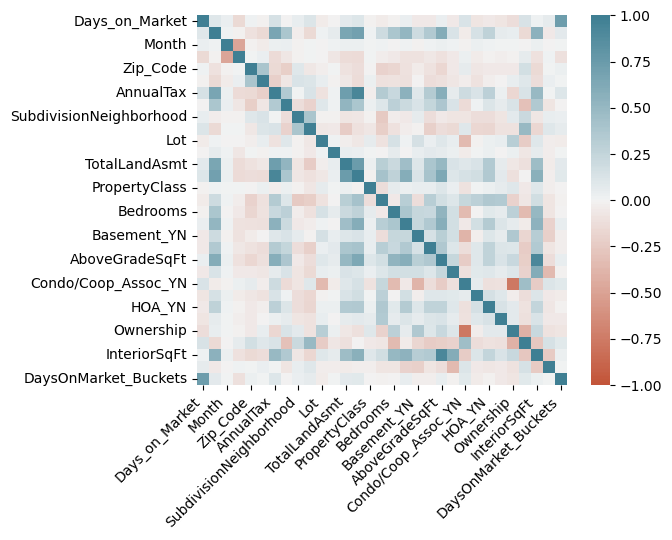

In [91]:
import seaborn as sns

corr = clean_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Balanced Random Forest Classifier

In [64]:
y = clean_df["DaysOnMarket_Buckets"]
X = clean_df.drop(columns=["Days_on_Market", "DaysOnMarket_Buckets"])

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(3764, 29)

In [66]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=20)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=20)

In [67]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.45428920840839254

In [68]:
# List the features sorted in descending order by feature importance
sorted(zip(brf.feature_importances_, X.columns), reverse=True)

[(0.07225780998977868, 'AnnualTax'),
 (0.06970975277287692, 'Orig_List_Price'),
 (0.06640489106136874, 'LotAcres'),
 (0.0660448535343922, 'SubdivisionNeighborhood'),
 (0.06093093277159518, 'TotalBldgAsmt'),
 (0.05916650609692979, 'Lot'),
 (0.057673258357971505, 'YearBuilt'),
 (0.057141748451849904, 'Age'),
 (0.05652210322152377, 'TotalLandAsmt'),
 (0.054469027413499446, 'InteriorSqFt'),
 (0.05281199541269077, 'AboveGradeSqFt'),
 (0.05074649806155715, 'Month'),
 (0.035645958454147135, 'NumberofStories'),
 (0.033409923315274516, 'Zip_Code'),
 (0.03033076576664324, 'Municipality'),
 (0.029677532752676674, 'Year'),
 (0.024842323509628717, 'BelowGradeSqFt'),
 (0.02070550423731667, 'Structure_Type'),
 (0.018935376128359396, 'SchoolDistrict'),
 (0.018837498885473262, 'Baths'),
 (0.017967606321315614, 'Bedrooms'),
 (0.009432560016750653, 'HOA_YN'),
 (0.008672903372005845, 'Garage_YN'),
 (0.00730552476744451, 'OwnerOccupied'),
 (0.0070667588096725385, 'Basement_YN'),
 (0.006824184971334893, 'Ce

In [69]:
# Drop columns from clean_df
updated_df = clean_df.drop(columns=["PropertyClass", "Condo/Coop_Assoc_YN", "Ownership", "OwnerOccupied", "HOA_YN", "Basement_YN", "Central_Air_YN"])
updated_df

,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,...,Bedrooms,Baths,Garage_YN,AboveGradeSqFt,BelowGradeSqFt,Age,Structure_Type,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
MLSNumber,,,,,,,,,,,,,,,,,,,,,
DENC518086,5.0,330000.0,12,2020,13,4,2151,0.26,445,4,...,4.0,2.0,2,2099.0,0.0,1958.0,1,2099.0,27,1
DENC518982,47.0,215500.0,1,2021,13,4,1824,0.06,385,4,...,3.0,2.0,1,1575.0,352.0,1976.0,4,1927.0,27,1
DENC512992,15.0,200000.0,12,2020,13,4,1563,0.05,600,4,...,2.0,2.0,1,1150.0,0.0,1985.0,4,1150.0,27,1
DENC512104,11.0,219900.0,10,2020,13,4,2174,0.05,184,4,...,2.0,3.0,2,1425.0,0.0,1985.0,4,1425.0,27,1
DENC503480,3.0,190000.0,6,2020,13,4,1349,0.17,526,2,...,3.0,2.0,1,925.0,0.0,1957.0,1,925.0,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DENC2013538,5.0,589900.0,12,2021,1,4,3503,0.82,39,4,...,4.0,2.0,2,2425.0,0.0,1957.0,1,2425.0,11,1
DENC520114,5.0,595000.0,6,2021,1,4,4311,1.03,83,4,...,3.0,2.0,2,3045.0,0.0,1958.0,1,3045.0,11,1
DENC2014038,7.0,529900.0,1,2022,1,4,4407,0.39,470,4,...,4.0,3.0,2,2850.0,341.0,1989.0,1,3191.0,12,1


In [70]:
y = updated_df["DaysOnMarket_Buckets"]
X = updated_df.drop(columns=["Days_on_Market", "DaysOnMarket_Buckets"])

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(3764, 22)

In [72]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=20)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=20)

In [73]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.4069047619047619

In [74]:
# List the features sorted in descending order by feature importance
sorted(zip(brf.feature_importances_, X.columns), reverse=True)

[(0.07744322181862351, 'Orig_List_Price'),
 (0.07343327001351205, 'AnnualTax'),
 (0.07280949084119924, 'SubdivisionNeighborhood'),
 (0.0673592505320976, 'TotalBldgAsmt'),
 (0.062221894732644875, 'TotalLandAsmt'),
 (0.06211474538801989, 'YearBuilt'),
 (0.06190698646193807, 'Age'),
 (0.060932170954732814, 'LotAcres'),
 (0.06052709888821844, 'Lot'),
 (0.0563938950872475, 'AboveGradeSqFt'),
 (0.05097545433801429, 'InteriorSqFt'),
 (0.04615672904710401, 'Month'),
 (0.03528664304350141, 'NumberofStories'),
 (0.034265293577514205, 'Zip_Code'),
 (0.03327991183646399, 'Municipality'),
 (0.031283198088246984, 'Year'),
 (0.023081759962098623, 'SchoolDistrict'),
 (0.02213921058730793, 'BelowGradeSqFt'),
 (0.019855742535370948, 'Bedrooms'),
 (0.01971318393148942, 'Structure_Type'),
 (0.016942299926143503, 'Baths'),
 (0.011878548408510513, 'Garage_YN')]

In [75]:
# Drop columns from clean_df
updated_df2 = updated_df.drop(columns=["Garage_YN", "Structure_Type", "Lot", "Baths", "SchoolDistrict", "Bedrooms", "BelowGradeSqFt", "Municipality", "YearBuilt", "Zip_Code"])
updated_df2

,Days_on_Market,Orig_List_Price,Month,Year,AnnualTax,LotAcres,SubdivisionNeighborhood,TotalLandAsmt,TotalBldgAsmt,AboveGradeSqFt,Age,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
MLSNumber,,,,,,,,,,,,,,
DENC518086,5.0,330000.0,12,2020,2151,0.26,445,12600,52600,2099.0,1958.0,2099.0,27,1
DENC518982,47.0,215500.0,1,2021,1824,0.06,385,9900,45400,1575.0,1976.0,1927.0,27,1
DENC512992,15.0,200000.0,12,2020,1563,0.05,600,9400,38000,1150.0,1985.0,1150.0,27,1
DENC512104,11.0,219900.0,10,2020,2174,0.05,184,8600,57300,1425.0,1985.0,1425.0,27,1
DENC503480,3.0,190000.0,6,2020,1349,0.17,526,8600,32300,925.0,1957.0,925.0,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DENC2013538,5.0,589900.0,12,2021,3503,0.82,39,25500,80700,2425.0,1957.0,2425.0,11,1
DENC520114,5.0,595000.0,6,2021,4311,1.03,83,31300,99400,3045.0,1958.0,3045.0,11,1
DENC2014038,7.0,529900.0,1,2022,4407,0.39,470,30000,103600,2850.0,1989.0,3191.0,12,1


In [76]:
y = updated_df2["DaysOnMarket_Buckets"]
X = updated_df2.drop(columns=["Days_on_Market", "DaysOnMarket_Buckets"])

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(3764, 12)

In [78]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=20)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=1000, random_state=20)

In [79]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.48668569004335716

In [80]:
# List the features sorted in descending order by feature importance
sorted(zip(brf.feature_importances_, X.columns), reverse=True)

[(0.10655894864263121, 'SubdivisionNeighborhood'),
 (0.1031941823153577, 'LotAcres'),
 (0.10266241580474178, 'Orig_List_Price'),
 (0.09643349804986133, 'AnnualTax'),
 (0.09376830477301452, 'Age'),
 (0.08844674062768652, 'TotalLandAsmt'),
 (0.0876111781493884, 'TotalBldgAsmt'),
 (0.08277264724127241, 'AboveGradeSqFt'),
 (0.08229991329018416, 'InteriorSqFt'),
 (0.06846255192155842, 'Month'),
 (0.046559661791038494, 'NumberofStories'),
 (0.041229957393264995, 'Year')]

In [89]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[  2,   5,   1],
       [440, 477, 280],
       [ 12,  15,  23]], dtype=int64)

### EasyEnsembleClassifier

In [81]:
y = clean_df["DaysOnMarket_Buckets"]
X = clean_df.drop(columns=["Days_on_Market", "DaysOnMarket_Buckets"])

In [82]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_jobs=-1, random_state=100)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_jobs=-1, random_state=100)

In [83]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.4419461348570812

In [84]:
# Drop columns from clean_df
updated_df = clean_df.drop(columns=["PropertyClass", "Condo/Coop_Assoc_YN", "Ownership", "Basement_YN"])
updated_df

,Days_on_Market,Orig_List_Price,Month,Year,Zip_Code,SchoolDistrict,AnnualTax,LotAcres,SubdivisionNeighborhood,Municipality,...,Garage_YN,AboveGradeSqFt,BelowGradeSqFt,Central_Air_YN,HOA_YN,Age,Structure_Type,InteriorSqFt,NumberofStories,DaysOnMarket_Buckets
MLSNumber,,,,,,,,,,,,,,,,,,,,,
DENC518086,5.0,330000.0,12,2020,13,4,2151,0.26,445,4,...,2,2099.0,0.0,2,2,1958.0,1,2099.0,27,1
DENC518982,47.0,215500.0,1,2021,13,4,1824,0.06,385,4,...,1,1575.0,352.0,2,1,1976.0,4,1927.0,27,1
DENC512992,15.0,200000.0,12,2020,13,4,1563,0.05,600,4,...,1,1150.0,0.0,2,1,1985.0,4,1150.0,27,1
DENC512104,11.0,219900.0,10,2020,13,4,2174,0.05,184,4,...,2,1425.0,0.0,2,2,1985.0,4,1425.0,27,1
DENC503480,3.0,190000.0,6,2020,13,4,1349,0.17,526,2,...,1,925.0,0.0,2,1,1957.0,1,925.0,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DENC2013538,5.0,589900.0,12,2021,1,4,3503,0.82,39,4,...,2,2425.0,0.0,2,1,1957.0,1,2425.0,11,1
DENC520114,5.0,595000.0,6,2021,1,4,4311,1.03,83,4,...,2,3045.0,0.0,2,2,1958.0,1,3045.0,11,1
DENC2014038,7.0,529900.0,1,2022,1,4,4407,0.39,470,4,...,2,2850.0,341.0,2,1,1989.0,1,3191.0,12,1


In [85]:
y = updated_df["DaysOnMarket_Buckets"]
X = updated_df.drop(columns=["Days_on_Market", "DaysOnMarket_Buckets"])

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape

(3764, 25)

In [87]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_jobs=-1, random_state=50)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_jobs=-1, random_state=50)

In [88]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.36949874686716794